In [1]:
import sys
sys.path.append('../') 


%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import seaborn as sns
sns.set()

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict
from shared_models import SharedModel
from collections import defaultdict 



## Params:

In [2]:
aggregate_by_state = False
outcome_type = 'deaths'

## Basic Data Visualization

In [3]:
# Just something to quickly summarize the number of cases and distributions each day

In [4]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../data/')
# df = df.sort_values('#Deaths_3/30/2020', ascending=False)
# outcome_cases = load_data.outcome_cases # most recent day
# outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
#                        'MedicareEnrollment,AgedTot2017',
                       'Respiratory Mortality',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
#                        'PopMale60-642010',
#                         'PopFmle60-642010',
#                          'PopMale65-742010',
#                          'PopFmle65-742010',
#                          'PopMale75-842010',
#                          'PopFmle75-842010',
#                          'PopMale>842010',
#                          'PopFmle>842010'
                      ]

loaded and merged COVID-19 cases/deaths data successfully


In [5]:
import data
df = data.load_county_data(data_dir = '../data/', cached=False,abridged=False)


../data/__init__.py:130: DtypeWarning: Columns (14,16,24,45,46) have mixed types.Specify dtype option on import or set low_memory=False.


loaded and cleaned ahrf_health successfully
loaded and cleaned cdc_svi successfully
loaded and cleaned chrr_health successfully
loaded and cleaned dhdsp_heart successfully
loaded and cleaned dhdsp_stroke successfully
loaded and cleaned hpsa_shortage successfully
loaded and cleaned ihme_respiratory successfully
loaded and cleaned khn_icu successfully


  2%|▏         | 64/3155 [00:00<00:04, 630.85it/s]

loaded and cleaned medicare_chronic successfully


100%|██████████| 3155/3155 [00:04<00:00, 631.42it/s]


loaded and cleaned mit_voting successfully
loaded and cleaned nchs_mortality successfully
loaded and cleaned usdss_diabetes successfully
loaded and cleaned jhu_interventions successfully


../data/__init__.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.countyFIPS[df.countyFIPS == "02158"] = "02270"


saved county_data.csv successfully
loaded and merged COVID-19 cases/deaths data successfully


In [8]:
from datetime import date 

In [9]:
first_date = date(2020,1,22)
first_ordinal = first_date.toordinal()

In [10]:
days_since_order = []
past_one_week = []
past_two_weeks = []
shelter_in_place_orders = list(df['stay at home'])
nan_counties = []
total_num_days = len(list(df['deaths'])[0])
for j,order in enumerate(shelter_in_place_orders):
    county_days_since_orders = []
    county_one_week = []
    county_two_week = []
    if np.isnan(order):
        nan_counties.append(list(df['CountyName'])[j]+ ' '+list(df['StateName'])[j])
        order = 1e10
    for i in range(total_num_days):
        current_date = first_ordinal+i
        county_days_since_orders.append(max(current_date-order,0))
        county_one_week.append(int(current_date > order + 7))
        county_two_week.append(int(current_date > order + 14))

    days_since_order.append(county_days_since_orders)
    past_one_week.append(county_one_week)
    past_two_weeks.append(county_two_week)

df['days_since_order'] = days_since_order
df['week_since_order'] = past_one_week
df['two_weeks_since_order'] = past_two_weeks



In [11]:
neighboring_counties_df = pd.read_csv('../data/county_level/raw/county_ids/county_adjacency2010.csv')

In [12]:
df['countyFIPS'] = [int(v) for v in list(df['countyFIPS'])]

In [13]:
county_neighbor_deaths = []
county_neighbor_cases = []
county_fips = list(df['countyFIPS'])
number_of_days = len(list(df['deaths'])[0])
for fips in county_fips:
    neighboring_counties = list(neighboring_counties_df.loc[neighboring_counties_df['fipscounty'] == fips]['fipsneighbor'])
    neighboring_county_deaths = list(df.loc[df['countyFIPS'].isin(neighboring_counties)]['deaths'])
    neighboring_county_cases = list(df.loc[df['countyFIPS'].isin(neighboring_counties)]['cases'])
    

    sum_neighboring_county_deaths = np.zeros(number_of_days)
    for deaths in neighboring_county_deaths:
        sum_neighboring_county_deaths += deaths
    sum_neighboring_county_cases = np.zeros(number_of_days)
    for cases in neighboring_county_cases:
        sum_neighboring_county_cases += cases
    county_neighbor_deaths.append(sum_neighboring_county_deaths)
    county_neighbor_cases.append(sum_neighboring_county_cases)



In [14]:
df['neighbor_deaths'] = county_neighbor_deaths
df['neighbor_cases'] = county_neighbor_cases


In [15]:
new_deaths = []
deaths = list(df['deaths'])
for county_deaths in deaths:
    county_new_deaths = []
    for i in range(len(list(county_deaths))):
        if i == 0: 
            county_new_deaths.append(list(county_deaths)[0])
        else:
            county_new_deaths.append(list(county_deaths)[i]-list(county_deaths)[i-1])

    smoothed_county_new_deaths = []
    window = 5
    for i in range(len(county_new_deaths)):
        start = max(i-window,0)
        end = min(i+window,len(county_new_deaths)-1)
        smoothed_county_new_deaths.append(sum(county_new_deaths[start:end])/len(county_new_deaths[start:end]))
        
    new_deaths.append(np.array(smoothed_county_new_deaths))
df['new_deaths'] = new_deaths

In [233]:
new_deaths = []
per_cap_deaths = []
deaths = list(df['deaths'])
pop = list(df['PopulationEstimate2018'])
for county_ind,county_deaths in enumerate(deaths):
    county_per_cap_deaths = []
    for i in range(len(list(county_deaths))):
        county_per_cap_deaths.append(list(county_deaths)[i]/pop[county_ind]*100000)
        
    per_cap_deaths.append(np.array(county_per_cap_deaths))
    
df['deaths_per_cap'] = per_cap_deaths

In [17]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

Number of counties with non-zero cases
2744


(array([232., 129.,  95.,  65.,  56.,  48.,  50.,  34.,  23.,  29.,  26.,
         17.,  29.,  17.,  10.,  15.,  19.,   8.,  14.,  11.,   9.,   6.,
          7.,   9.,  10.,   3.,  10.,   7.,   5.,   5.,   6.,   4.,   9.,
          4.,   4.,   3.,   5.,   9.,   4.,   0.,   7.,   7.,   5.,   2.,
          3.,   0.,   2.,   2.,   3.,   5.,   3.,   3.,   2.,   2.,   2.,
          0.,   1.,   2.,   0.,   6.,   3.,   3.,   0.,   2.,   2.,   1.,
          2.,   1.,   3.,   2.,   1.,   1.,   0.,   2.,   0.,   0.,   0.,
          1.,   1.,   2.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   1.,
          2.,   1.,   1.,   0.,   0.,   1.,   0.,   2.,   0.,   0.,   4.,
          1.]),
 array([ 21.  ,  30.66,  40.32,  49.98,  59.64,  69.3 ,  78.96,  88.62,
         98.28, 107.94, 117.6 , 127.26, 136.92, 146.58, 156.24, 165.9 ,
        175.56, 185.22, 194.88, 204.54, 214.2 , 223.86, 233.52, 243.18,
        252.84, 262.5 , 272.16, 281.82, 291.48, 301.14, 310.8 , 320.46,
        330.12, 339.78, 349.44

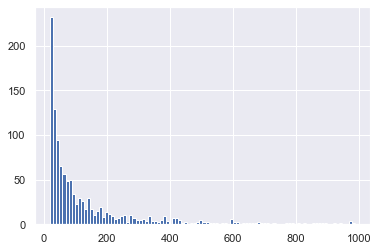

In [18]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))

print('Number of counties with non-zero cases')
print(sum([v >0 for v in max_cases]))


# cases truncated below 20 and above 1000 for plot readability
plt.hist([v for v in max_cases if v > 20 and v < 1000],bins = 100)


In [19]:
sum(max_cases)

771576

In [20]:
print(sum([v > 50 for v in max_cases]))


798


In [21]:
np.quantile(max_cases,.5)

12.0

Number of counties with non-zero deaths
1249


(array([379.,  14.,  12.,   7.,   4.,   1.,   1.,   3.,   1.,   0.,   1.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([   6. ,  114.5,  223. ,  331.5,  440. ,  548.5,  657. ,  765.5,
         874. ,  982.5, 1091. , 1199.5, 1308. , 1416.5, 1525. , 1633.5,
        1742. , 1850.5, 1959. , 2067.5, 2176. , 2284.5, 2393. , 2501.5,
        2610. , 2718.5, 2827. , 2935.5, 3044. , 3152.5, 3261. ]),
 <a list of 30 Patch objects>)

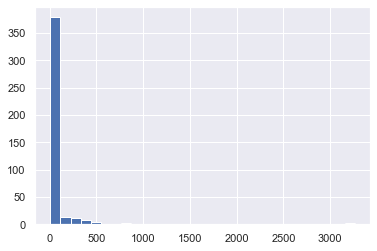

In [22]:
# Distribution of the maximum number of cases
_deaths = list(df['deaths'])

max_deaths = []
for i in range(len(df)):
    max_deaths.append(max(_deaths[i]))

    
print('Number of counties with non-zero deaths')
print(sum([v > 0 for v in max_deaths]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_deaths if v > 5],bins=30)

In [23]:
sum(max_deaths)

37039

In [24]:
max(max_deaths)

3261

In [25]:
np.quantile(max_deaths,.7)

1.0

### Clean data

In [26]:
# Remove counties with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
max_deaths = [max(v) for v in df['deaths']]
df['max_deaths'] = max_deaths
df =  df[df['max_cases'] > 0]



## Predict data from model:

In [27]:
method_keys = []

In [28]:
# clear predictions
for m in method_keys:
    del df[m]
    

In [29]:
# target_day = np.array([1])
# # Trains model on train_df and produces predictions for the final day for test_df and writes prediction
# # to a new column for test_df 
# # fit_and_predict(df, method='exponential', outcome=outcome_type, mode='eval_mode',target_day=target_day)
# # fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',target_day=target_day)
# # fit_and_predict(train_df, test_df,'shared_exponential', mode='eval_mode',demographic_vars=important_vars)
# # fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',demographic_vars=very_important_vars,target_day=target_day)
# fit_and_predict(df, outcome=outcome_type, mode='eval_mode',demographic_vars=[],
#                                      method='ensemble',target_day=target_day)
# fit_and_predict(df, outcome=outcome_type, mode='eval_mode',demographic_vars=[],
#                                      method='ensemble',target_day=np.array([1,2,3]))
# # fit_and_predict(train_df, test_d f,method='exponential',mode='eval_mode',target_day = np.array([1,2]))

# # Finds the names of all the methods
# method_keys = [c for c in df if 'predicted' in c]
# method_keys

In [30]:
# for days_ahead in [1, 2, 3]:
#      for method in ['exponential', 'shared_exponential', 'ensemble']:  
#         fit_and_predict(df, method=method, outcome=outcome_type, mode='eval_mode',target_day=np.array([days_ahead]))
        
#         if method == 'shared_exponential':
#             fit_and_predict(df,method='shared_exponential', 
#                             outcome=outcome_type, 
#                              mode='eval_mode',
#                              demographic_vars=very_important_vars,
#                              target_day=np.array([days_ahead]))
# method_keys = [c for c in df if 'predicted' in c]
# geo = ['countyFIPS', 'CountyNamew/StateAbbrev']

In [31]:
# method_keys = [c for c in df if 'predicted' in c]
# df_preds = df[method_keys + geo + ['deaths']]
# df_preds.to_pickle("multi_day_6.pkl")

## Ensemble predictions

In [32]:
exponential = {'model_type':'exponential'}
shared_exponential = {'model_type':'shared_exponential'}
demographics = {'model_type':'shared_exponential', 'demographic_vars':very_important_vars}
linear = {'model_type':'linear'}

In [33]:
# import fit_and_predict
# for d in [1, 2, 3]:
#     df = fit_and_predict.fit_and_predict_ensemble(df, 
#                                                   target_day=np.array([d]),
#                                                   mode='eval_mode',
#                                                   outcome=outcome_type,
#                                                   output_key=f'predicted_{outcome_type}_ensemble_{d}'
#                                                    )

In [34]:
feat_transforms = defaultdict(lambda y: [lambda x: x]) 
# feat_transforms['deaths'] = [lambda x: np.log(x+1),lambda x: np.log(np.log(x+1)+1)]
# feat_transforms['cases'] =  [lambda x: np.log(x+1),lambda x: np.log(np.log(x+1)+1)]
# feat_transforms['neighbor_deaths'] =  [lambda x: np.log(x+1),lambda x: np.log(np.log(x+1)+1)]
# feat_transforms['neighbor_cases'] = [lambda x: np.log(x+1),lambda x: np.log(np.log(x+1)+1)]


feat_transforms['deaths_per_cap'] = [lambda x: np.log(x+1)]


feat_transforms['days_since_order'] = [lambda x: x]
feat_transforms['week_since_order'] =  [lambda x: x]
feat_transforms['two_weeks_since_order'] =  [lambda x: x]


feat_transforms['deaths'] = [lambda x: np.log(x+1)]
feat_transforms['new_deaths'] = [lambda x: np.log(x+1)]
feat_transforms['cases'] =  [lambda x: np.log(x+1)]
feat_transforms['neighbor_deaths'] =  [lambda x: np.log(x+1)]
feat_transforms['neighbor_cases'] =  [lambda x: np.log(x+1)]
default_values = defaultdict(lambda: 0) 

In [35]:
outcome_type

'deaths'

In [183]:
d = 7

In [184]:
# shared_model = SharedModel(df=df,outcome=outcome_type,demographic_variables=[],mode='eval_mode',target_days=np.array(range(1,8)),
#                            feat_transforms=feat_transforms,auxiliary_time_features=['cases','neighbor_deaths','neighbor_cases'], 
#                            time_series_default_values=default_values,scale=True,include_diffs=True )





shared_model = SharedModel(df=df,outcome=outcome_type,demographic_variables=[],mode='eval_mode',target_days=np.array(range(1,d+1)),
                           feat_transforms=feat_transforms,auxiliary_time_features=['week_since_order'], 
                           time_series_default_values=default_values,scale=True,include_diffs=False )


shared_model.create_dataset()

shared_model.fit_model()


shared_model.predict()

print(shared_model.model.params)
df['predicted_week'] = shared_model.predictions

[ 1.14115766 -0.03255934  2.30324813]


In [287]:

# shared_model = SharedModel(df=df,outcome=outcome_type,demographic_variables=[],mode='eval_mode',target_days=np.array(range(1,d+1)),
#                            feat_transforms=feat_transforms,auxiliary_time_features=['two_weeks_since_order'], 
#                            time_series_default_values=default_values,scale=False,include_diffs=False )


# shared_model.create_dataset()

# shared_model.fit_model()


# shared_model.predict()

# print(shared_model.model.params)
# df['predicted_two_weeks'] = shared_model.predictions

In [41]:

shared_model = SharedModel(df=df,outcome=outcome_type,demographic_variables=[],mode='eval_mode',target_days=np.array(range(1,d+1)),
                           feat_transforms=feat_transforms,auxiliary_time_features=['days_since_order'], 
                           time_series_default_values=default_values,scale=True,include_diffs=False )


shared_model.create_dataset()

shared_model.fit_model()


shared_model.predict()

print(shared_model.model.params)
df['predicted_days'] = shared_model.predictions

[ 1.0739829  -0.01226855  2.20256197]


In [42]:

shared_model = SharedModel(df=df,outcome=outcome_type,demographic_variables=[],mode='eval_mode',target_days=np.array(range(1,d+1)),
                           feat_transforms=feat_transforms,auxiliary_time_features=[], 
                           time_series_default_values=default_values,scale=True,include_diffs=False )


shared_model.create_dataset()

shared_model.fit_model()


shared_model.predict()

print(shared_model.model.params)
df['predicted_vanilla'] = shared_model.predictions

[1.06996968 2.20305559]


In [70]:
import statsmodels.api as sm


In [87]:

shared_model = SharedModel(df=df,outcome=outcome_type,demographic_variables=[],mode='eval_mode',target_days=np.array([d]),
                           feat_transforms=feat_transforms,auxiliary_time_features=[], 
                           time_series_default_values=default_values,scale=True,include_diffs=True , direct_predict = True, family = sm.families.Gaussian())


shared_model.create_dataset()

shared_model.fit_model()


shared_model.predict()

print(shared_model.model.params)
df['predicted_direct'] = shared_model.predictions

[79.05550523 -4.84056907 47.74001699]


In [38]:
advanced_model = {'model_type':'advanced_shared_model'}

In [39]:
# clear predictions
for m in method_keys:
    del df[m]
    
method_keys = [c for c in df if 'predicted' in c]
    

In [40]:
method_keys

[]

In [234]:
# outcome_type = 'new_deaths'
# outcome_type = 'deaths'
outcome_type = 'deaths_per_cap'

In [235]:
import fit_and_predict
for d in [7]:
    df = fit_and_predict.fit_and_predict_ensemble(df, 
                                                  target_day=np.array(range(1, d+1)),
                                                  mode='eval_mode',
                                                  outcome=outcome_type,
                                                  methods=[ 
#                                                       exponential, 
#                                                       demographics,
                                                      advanced_model,

                                                    
                                                    
                                                          linear
                                                         ],
                                                  output_key=f'predicted_{outcome_type}_ensemble_{d}_with_advanced',
                                                  verbose=True
                                                   ) 

--- Model Contributions ---
{'model_type': 'linear'}: 0.6870601916675038
{'model_type': 'advanced_shared_model'}: 0.31293980833249546


In [236]:
import fit_and_predict
for d in [7]:
    df = fit_and_predict.fit_and_predict_ensemble(df, 
                                                  target_day=np.array(range(1, d+1)),
                                                  mode='eval_mode',
                                                  outcome=outcome_type,
                                                  methods=[ 
#                                                       exponential, 
#                                                            shared_exponential,
#                                                       demographics,
                                                      advanced_model

                                                    
                                                    
                                                          
                                                         ],
                                                  output_key=f'predicted_{outcome_type}_advanced'
                                                   ) 

In [237]:
import fit_and_predict
for d in [7]:
    df = fit_and_predict.fit_and_predict_ensemble(df, 
                                                  target_day=np.array(range(1, d+1)),
                                                  mode='eval_mode',
                                                  outcome=outcome_type,
                                                  methods=[ 
#   

                                                          linear
                                                         ],
                                                  output_key=f'predicted_{outcome_type}_linear'
                                                   ) 

In [238]:
method_keys = [c for c in df if 'predicted' in c]

In [239]:
method_keys

['predicted_deaths_ensemble_7_with_advanced',
 'predicted_deaths_advanced',
 'predicted_deaths_linear',
 'predicted_week',
 'predicted_deaths_per_cap_ensemble_7_with_advanced',
 'predicted_deaths_per_cap_advanced',
 'predicted_deaths_per_cap_linear']

In [240]:
# df['predicted_deaths_ensemble_3_with_cases'] = shared_model.predictions
# method_keys.append('predicted_deaths_ensemble_3_with_cases')


## Evaluate and visualize models

### Compute MSE and log MSE on relevant cases

In [241]:


# TODO: add average rank as metric

In [242]:
# Computes the mse in log space and non-log space for all columns

In [243]:
def l1(arr1,arr2,norm=True):
    """
    arr2 ground truth
    arr1 predictions
    """
    if norm:
        sum_percent_dif = 0
        for i in range(len(arr1)):
            sum_percent_dif += np.abs(arr2[i]-arr1[i])/arr1[i]
        return sum_percent_dif/len(arr1)
            
    return sum([np.abs(a1-a2) for (a1,a2) in zip(arr1,arr2)])/len(arr1)
mse = sklearn.metrics.mean_squared_error
# Only evaluate points that exceed this number of deaths 
# lower_threshold, upper_threshold = 10, 100000
lower_threshold, upper_threshold = 10, np.inf
if outcome_type == 'deaths_per_cap':
    lower_threshold = lower_threshold/np.mean(list(df['PopulationEstimate2018']))

In [244]:

# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][(outcome > lower_threshold)]] # * (outcome < upper_threshold)]]
    print('Log scale MSE for '+key)
    print(mse(np.log(outcome[(outcome > lower_threshold) * (outcome < upper_threshold)] + 1),preds))

Log scale MSE for predicted_deaths_ensemble_7_with_advanced
1.1571695686324406
Log scale MSE for predicted_deaths_advanced
1.3721562582949949
Log scale MSE for predicted_deaths_linear


/Users/nick/anaconda2/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [245]:
# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][outcome > lower_threshold]]
    print('Log scale l1 for '+key)
    print(l1(np.log(outcome[outcome > lower_threshold] + 1),preds))

Log scale l1 for predicted_deaths_ensemble_7_with_advanced
0.5931788316229516
Log scale l1 for predicted_deaths_advanced
0.8398838777269281
Log scale l1 for predicted_deaths_linear
nan
Log scale l1 for predicted_week
0.8356013238730131
Log scale l1 for predicted_deaths_per_cap_ensemble_7_with_advanced
0.2993359216120823
Log scale l1 for predicted_deaths_per_cap_advanced
0.38466423932164245
Log scale l1 for predicted_deaths_per_cap_linear
nan


/Users/nick/anaconda2/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [246]:
#alpha = .01, 1600.2934499171229

In [247]:
# alpha = 0, 1542.4338963814796

In [248]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw MSE for '+key)
    print(mse(outcome[outcome > lower_threshold],preds))

Raw MSE for predicted_deaths_ensemble_7_with_advanced
26107.854979188956
Raw MSE for predicted_deaths_advanced
41428.57884441289
Raw MSE for predicted_deaths_linear
24509.834046833763
Raw MSE for predicted_week
77750.56934357138
Raw MSE for predicted_deaths_per_cap_ensemble_7_with_advanced
63.58879998405422
Raw MSE for predicted_deaths_per_cap_advanced
1143.6420590264463
Raw MSE for predicted_deaths_per_cap_linear
70.6051452719356


In [249]:
#[alpha = .01, 1122.4187100081517]
#[alpha = .001, 1103.7477272612207]
#[alpha = 0,1101.7658699463036]

In [250]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds))

Raw l1 for predicted_deaths_ensemble_7_with_advanced
2.107898663739769
Raw l1 for predicted_deaths_advanced
3.6174393166946213
Raw l1 for predicted_deaths_linear
1.7093312083266405
Raw l1 for predicted_week
3.549473376233462
Raw l1 for predicted_deaths_per_cap_ensemble_7_with_advanced
0.5094833729840679
Raw l1 for predicted_deaths_per_cap_advanced
0.8564695298752129
Raw l1 for predicted_deaths_per_cap_linear
0.47524549155189444


In [251]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds,norm=False))

Raw l1 for predicted_deaths_ensemble_7_with_advanced
26.01565929105279
Raw l1 for predicted_deaths_advanced
31.13435805152488
Raw l1 for predicted_deaths_linear
25.303794062775662
Raw l1 for predicted_week
36.819166057774275
Raw l1 for predicted_deaths_per_cap_ensemble_7_with_advanced
3.649129140777713
Raw l1 for predicted_deaths_per_cap_advanced
7.026644797160941
Raw l1 for predicted_deaths_per_cap_linear
3.755816681788705


In [252]:
log:
Raw l1 for predicted_deaths_ensemble_7_with_advanced
19.845596402420583
Raw l1 for predicted_deaths_advanced
26.237137514377487
Raw l1 for predicted_deaths_linear
21.056293706293705

SyntaxError: invalid syntax (<ipython-input-252-d9766c024857>, line 1)

In [253]:
raw:
Raw l1 for predicted_deaths_ensemble_7_with_advanced
20.410665384226096
sqrt:
18.321209020555486
cube root 
19.03950964039404
4th root
19.702177479798


SyntaxError: invalid syntax (<ipython-input-253-aad39e3d1c01>, line 1)

In [254]:
Raw l1 for predicted_deaths_ensemble_7_with_advanced
19.63608849426789
Raw l1 for predicted_deaths_advanced
26.23713751437759
Raw l1 for predicted_deaths_linear
21.056293706293705

SyntaxError: invalid syntax (<ipython-input-254-e38605a8c833>, line 1)

### Plot residuals

In [255]:
# TODO: Create bounds automatically, create a plot function and call it instead of copying code, figure out way
# to plot more than two things at once cleanly

# Creates residual plots log scaled and raw
# We only look at cases with number of deaths greater than 5

In [256]:
def method_name_to_pretty_name(key):
    # TODO: hacky, fix
    return key
    words = key.split('_')
    words2 = []
    for w in words:
        if not w.isnumeric():
            words2.append(w)
        else:
            num = w
            
    model_name = ' '.join(words2[2:])
#     model_name = 'model'
    if num == '1':
        model_name += ' predicting 1 day ahead'
    else:
        model_name += ' predicting ' +w+' days ahead'
        
    return model_name

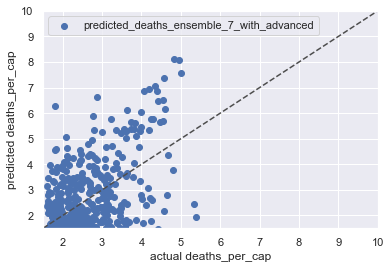

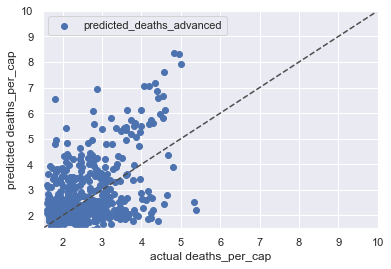

/Users/nick/anaconda2/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/nick/anaconda2/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


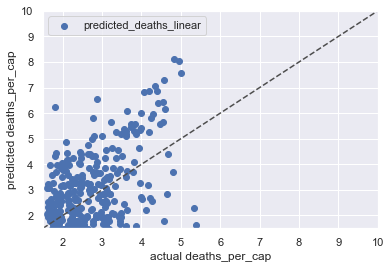

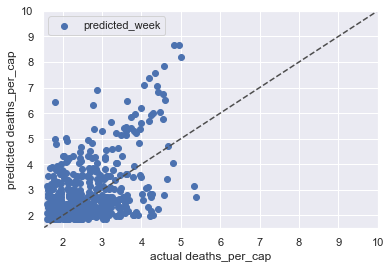

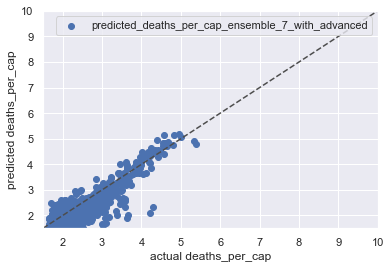

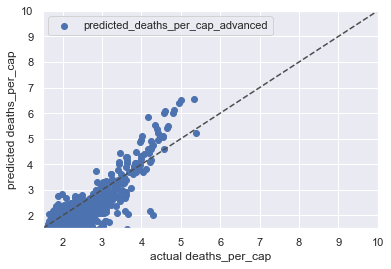

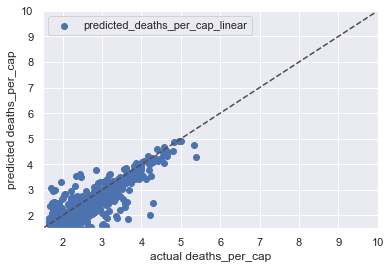

In [257]:
# Make log plots:
bounds = [1.5, 10]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=method_name_to_pretty_name(key))
    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

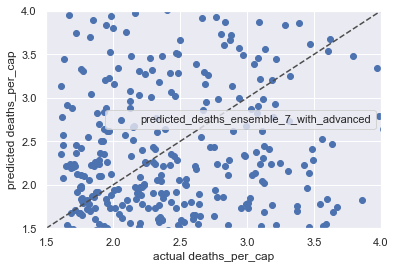

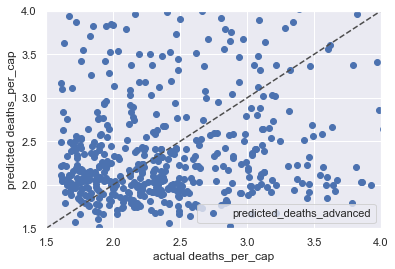

/Users/nick/anaconda2/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/nick/anaconda2/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


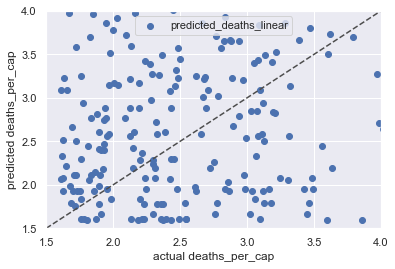

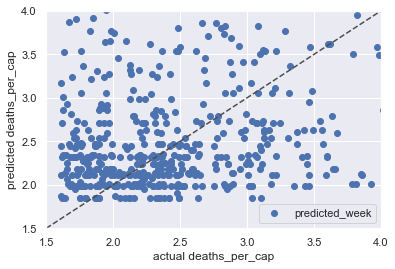

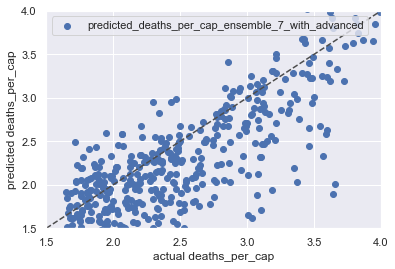

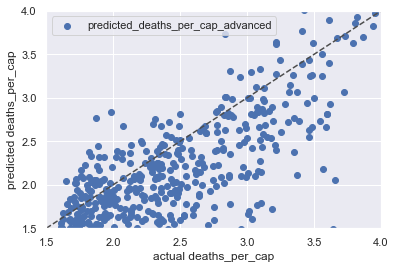

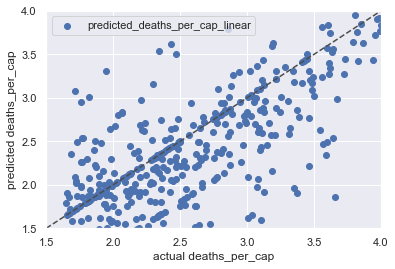

In [258]:
# Make log plots zoomed in for the counties that have a fewer number of deaths
bounds = [1.5, 4]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=method_name_to_pretty_name(key))

    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

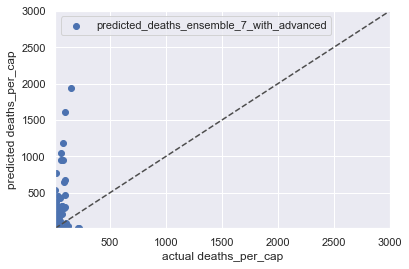

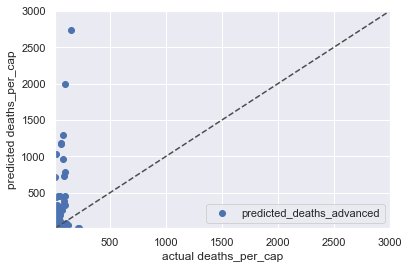

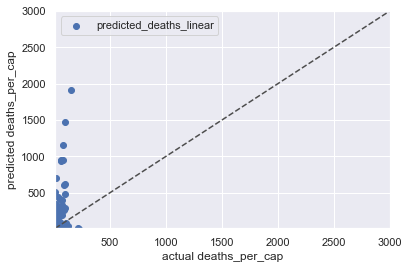

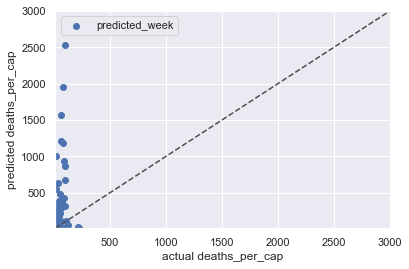

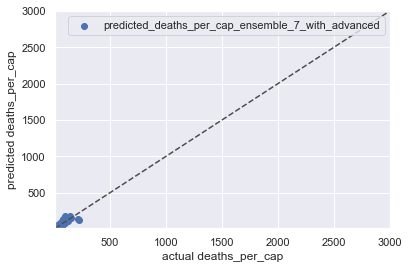

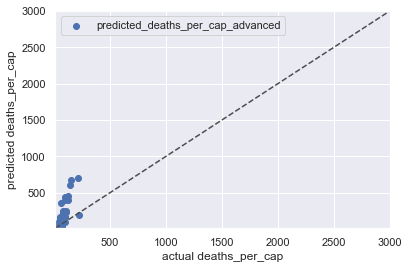

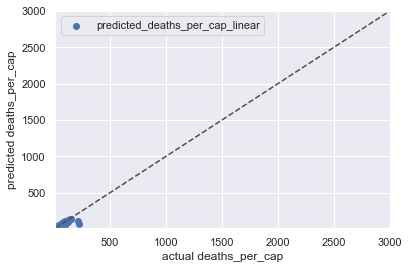

In [259]:
# Make non-log plots zoomed in for the counties that have a fewer number of deaths# We set bounds 
bounds = [10,3000]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > 5]]
    plt.scatter(outcome[outcome > 5],preds,label=method_name_to_pretty_name(key))

    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

### Graph Visualizations

In [260]:
# Here we visualize predictions on a per county level.
# The blue lines are the true number of deaths, and the dots are our predictions for each model for those days.

In [261]:
def plot_log(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = outcome_type
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    if len(row[gold_key][start_point:]) < 3:
        return
    values = [np.log(v+1) for v in list(row[outcome_type])[start_point:]]

    sns.lineplot(list(range(len(values))),values, label=outcome_type)

    
        
    
    


    plt.title(row['CountyName']+' in '+row['StateNameAbbreviation'])
    plt.ylabel(outcome_type)
    plt.xlabel('Days since first death')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(dpi=500)    
    plt.show()

    

In [262]:
def plot_ratio(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = outcome_type
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    if len(row[gold_key][start_point:]) < 3:
        return
    prev = 5
    ratios = []
    values = list(row[outcome_type])[start_point:]
    for i in range(len(values)):
        ratios.append((values[i]+5)/prev)
        prev = values[i]+5
    
    sns.lineplot(list(range(len(values))),ratios, label=outcome_type)

    
        
    
    


    plt.title(row['CountyName']+' in '+row['StateNameAbbreviation'])
    plt.ylabel(outcome_type)
    plt.xlabel('Days since first death')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(dpi=500)    
    plt.show()

    

In [263]:
start = len(df['deaths'][0])-20

In [264]:
death_dates = []
for c in df.columns:
    if '2020' in c and 'Deaths' in c:
        death_dates.append(c)

In [265]:
death_dates[start+12]

'#Deaths_04-13-2020'

In [266]:
def plot_prediction(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = outcome_type
    for i,val in enumerate(row[gold_key]):
        if val > 10:
            start_point = i
            break
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    start_point = len(row[gold_key])-20
    if len(row[gold_key][start_point:]) < 3:
        return
    sns.lineplot(list(range(len(row[gold_key][start_point:]))),row[gold_key][start_point:], label=gold_key)
    

    for key in method_keys:
        preds = row[key]

        sns.scatterplot(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=method_name_to_pretty_name(key))
        
#         plt.scatter(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=key)
    
#     plt.legend()
#     plt.show()
#     sns.legend()
    plt.title(row['CountyName']+' in '+row['StateName'])
    plt.ylabel(outcome_type)
    plt.xlabel('Days since first death')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(dpi=500)    
    plt.show()

    

In [267]:
# feature_vals = {
# 'PopulationDensityperSqMile2010' : 1.1525491065255939e-05,
# "MedicareEnrollment,AgedTot2017" : -2.119520577282583e-06,
# 'PopulationEstimate2018' : 2.8898343032154275e-07,
# '#ICU_beds' : -0.000647030727828718,
# 'MedianAge2010' : 0.05032666600339253,
# 'Smokers_Percentage' : -0.013410742818946319,
# 'DiabetesPercentage' : 0.04395318355581005,
# 'HeartDiseaseMortality' : 0.0015473771787186525,
# '#Hospitals': 0.019248102357644396,
# 'log(deaths)' : 0.8805209010821442,
# 'bias' : -1.871552103871495
# }

Kings in NY


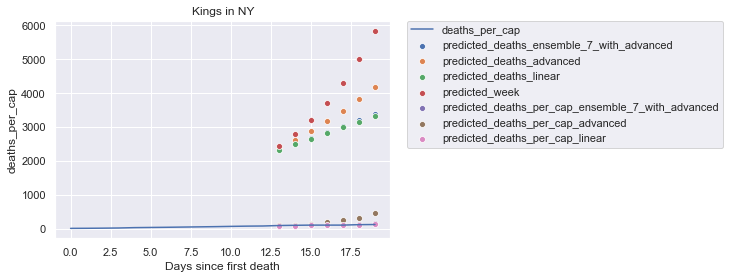

<Figure size 3000x2000 with 0 Axes>



Queens in NY


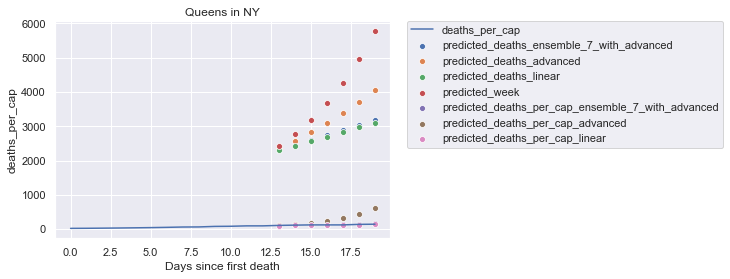

<Figure size 3000x2000 with 0 Axes>



Bronx in NY


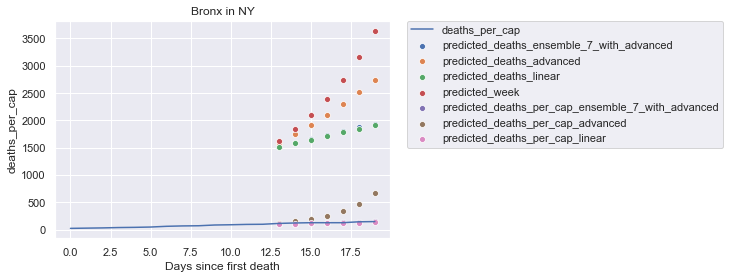

<Figure size 3000x2000 with 0 Axes>



Nassau in NY


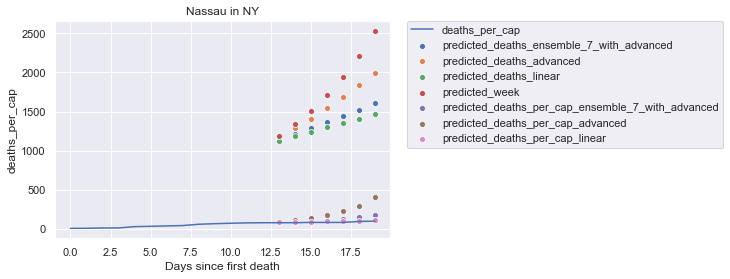

<Figure size 3000x2000 with 0 Axes>



New York in NY


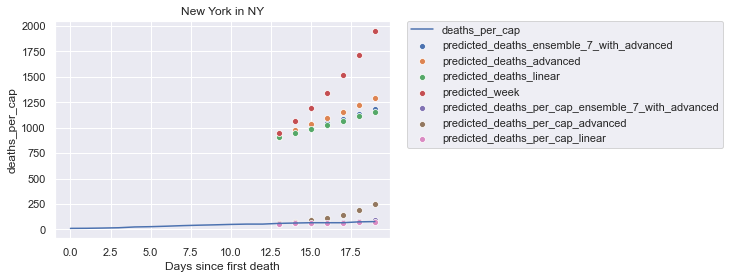

<Figure size 3000x2000 with 0 Axes>



Wayne in MI


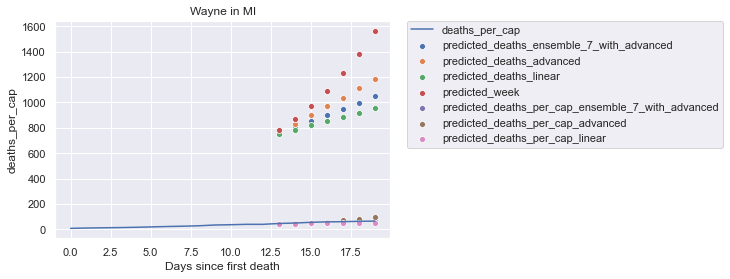

<Figure size 3000x2000 with 0 Axes>



Cook in IL


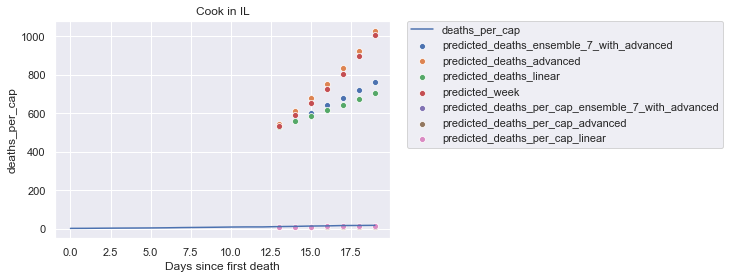

<Figure size 3000x2000 with 0 Axes>



Suffolk in NY


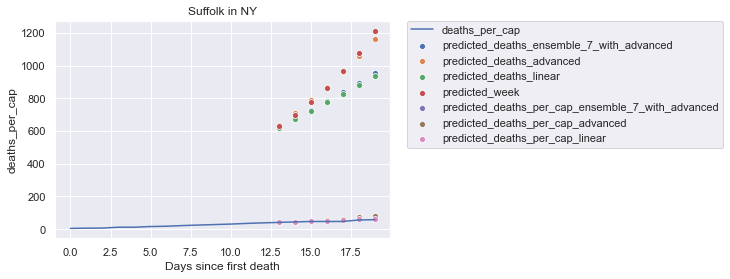

<Figure size 3000x2000 with 0 Axes>



Bergen in NJ


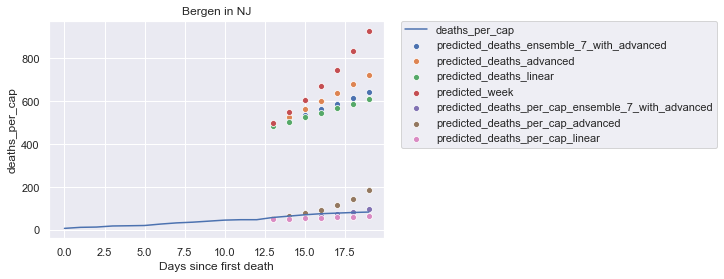

<Figure size 3000x2000 with 0 Axes>



Westchester in NY


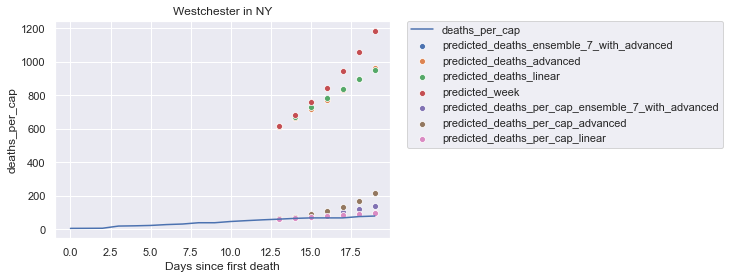

<Figure size 3000x2000 with 0 Axes>



Essex in NJ


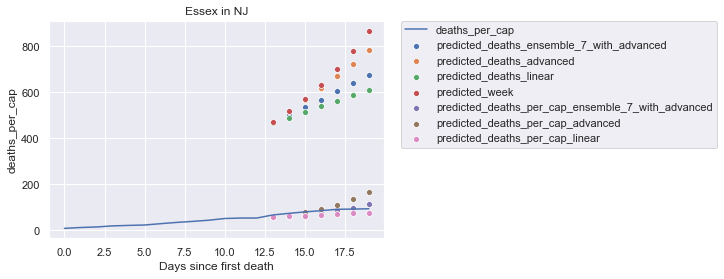

<Figure size 3000x2000 with 0 Axes>



Los Angeles in CA


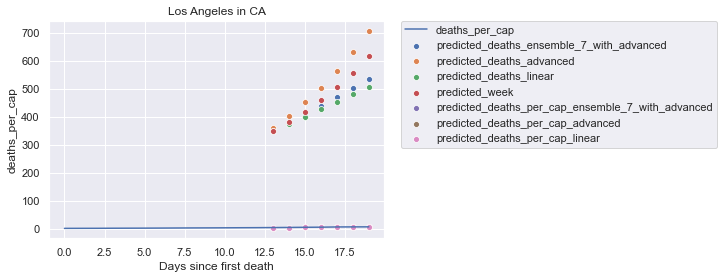

<Figure size 3000x2000 with 0 Axes>



Fairfield in CT


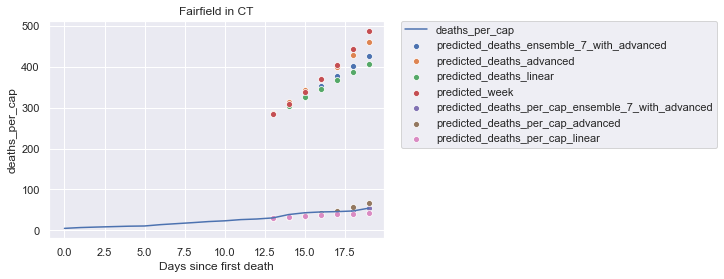

<Figure size 3000x2000 with 0 Axes>



Hudson in NJ


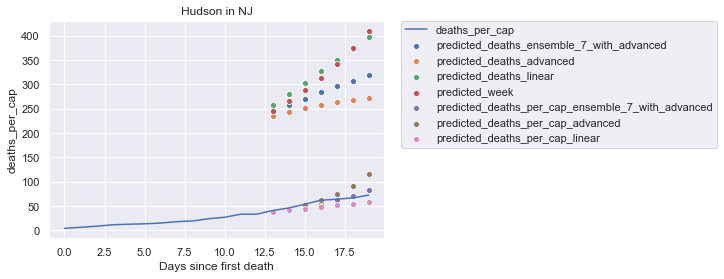

<Figure size 3000x2000 with 0 Axes>



Oakland in MI


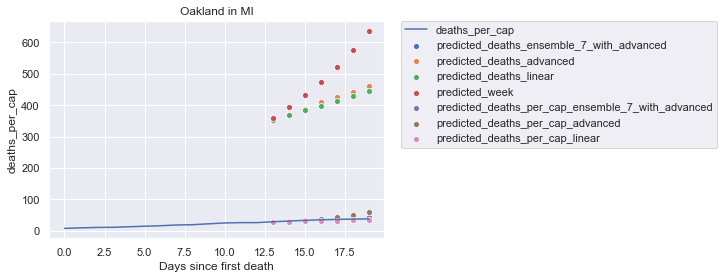

<Figure size 3000x2000 with 0 Axes>



Richmond in NY


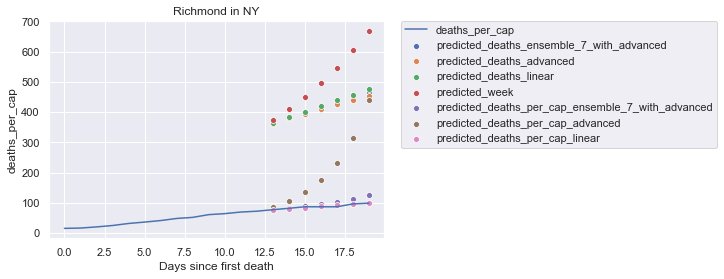

<Figure size 3000x2000 with 0 Axes>



Macomb in MI


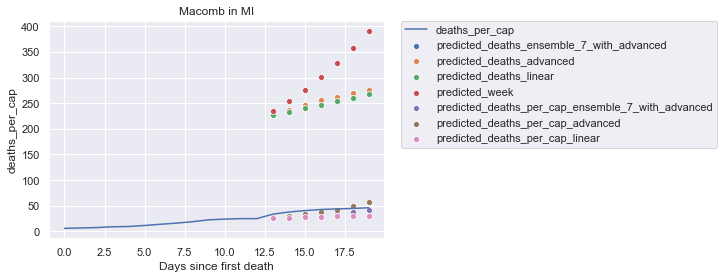

<Figure size 3000x2000 with 0 Axes>



Middlesex in MA


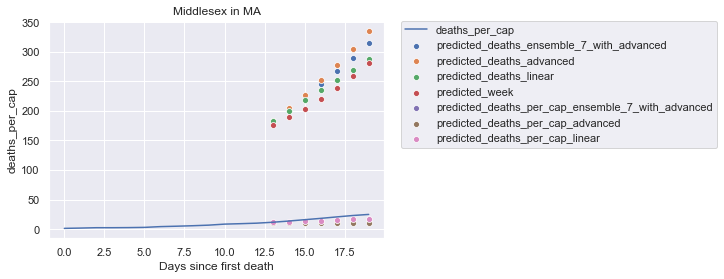

<Figure size 3000x2000 with 0 Axes>



Union in NJ


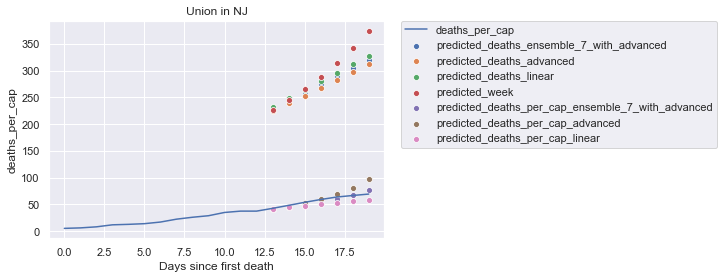

<Figure size 3000x2000 with 0 Axes>



Hartford in CT


KeyboardInterrupt: 

In [268]:
df = df.sort_values(by='max_deaths',ascending=False)
for i in range(len(df)):
    row = df.iloc[i]
    # If number of deaths greater than 10
    if max(row['deaths']) > 10:
        print(row['CountyName']+' in '+row['StateName'])
        plot_prediction(row)
#         plot_log(row)

#         for v in very_important_vars:
#             print(v+ ': '+str(row[v])) #+';\t contrib: '+ str(feature_vals[v]*float(row[v])))
        print('\n')